# GLUED - University Enrollment Data Analysis
- **Author:** Reggie Bain
- **Date:** June 3rd, 2023

1. Use entire dataset assuming "iau_id1" = unique institutions and "students5_estimated" is estimated enrollment.
2. How many private institutions are listed between 190 and 2020?
3. For how many private institutions does dataset provide estimated enrollment in 1950 and 2020 specifically?
4. What civil/geopolitical events are detectable from this dataset? Use one or more visualizations/anslyses to make observations about said event(s) and its affect on university enrollments. Ok if event is not observable in data.

In [2]:
# Key imports
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [4]:
# Get the data schema
schema = pd.read_csv('/Users/reggiebain/Dropbox/Data Science/college-board-analysis/datasets/enrollments_schema.csv')
schema.head()

,country,"Name of country. The default is the country name, merged in from the World Development Indicators. The name represents the country the institution is currently located in many country borders have changed over time and so this does not necessarily represent the name of the country when founded or historically."
0,countrycode,Three-letter code outlined by ISO 3166 alpha-3...
1,region,Region in which the institution is currently s...
2,incomegroup,"Income group, merged from the World Bank."
3,iau_id,This is a unique identifier for each universit...
4,iau_id1,This is a unique identifier specific to our da...


Just open the schema in separate window.

Our first step is to import the data and inspect to see data types, key columns, missing values, etc. Our initial DF will be called "raw" until it is processed.

In [7]:
# Import Data from Stata.
RAW_PATH = '/Users/reggiebain/Dropbox/Data Science/college-board-analysis/datasets/GLUED_Institutional_orig.dta'
raw = pd.read_stata(RAW_PATH)
raw.head()

,country,countrycode,region,incomegroup,iau_id,iau_id1,eng_name,orig_name,foundedyr,yrclosed,...,divisions,total_fields,unique_fields,specialized,merger,noiau,year,students5_interpolated,students5_extrapolated,students5_estimated
0,afghanistan,AFG,South Asia,Low income,IAU-000810,IAU-000810-1,Alberoni University,Alberoni University,1998.0,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,2000,NaN,1546.0,1546.0
1,afghanistan,AFG,South Asia,Low income,IAU-000810,IAU-000810-1,Alberoni University,Alberoni University,1998.0,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,2005,NaN,2106.0,2106.0
2,afghanistan,AFG,South Asia,Low income,IAU-000810,IAU-000810-1,Alberoni University,Alberoni University,1998.0,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,2010,2317.0,2317.0,2317.0
3,afghanistan,AFG,South Asia,Low income,IAU-000810,IAU-000810-1,Alberoni University,Alberoni University,1998.0,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,2015,1835.0,1835.0,1835.0
4,afghanistan,AFG,South Asia,Low income,IAU-000810,IAU-000810-1,Alberoni University,Alberoni University,1998.0,NaN,...,9.0,22.0,21.0,0.0,0.0,0.0,2020,NaN,1901.0,1901.0


In [23]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161615 entries, 0 to 161614
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   country                 161615 non-null  object 
 1   countrycode             161615 non-null  object 
 2   region                  161615 non-null  object 
 3   incomegroup             161615 non-null  object 
 4   iau_id                  161615 non-null  object 
 5   iau_id1                 161615 non-null  object 
 6   eng_name                161615 non-null  object 
 7   orig_name               161615 non-null  object 
 8   foundedyr               161615 non-null  int64  
 9   yrclosed                460 non-null     float64
 10  private01               161615 non-null  float32
 11  coordinates             161615 non-null  object 
 12  latitude                161615 non-null  object 
 13  longitude               161615 non-null  object 
 14  phd_granting        

In [8]:
#raw[~raw.yrclosed.isnull()] # Check on yrclosed null values
raw.year.unique() # Check for what years are represented

array([2000, 2005, 2010, 2015, 2020, 1990, 1995, 1980, 1985, 1950, 1955,
       1960, 1965, 1970, 1975], dtype=int16)

In [9]:
# Check to make sure there is only 1 entry for each institution in each year
def find_duplicates(df, year):
    year_data = df[df.year == year]
    n_entries = year_data.iau_id1.count() # Get non null entry count
    n_unique = year_data.iau_id1.nunique() # Get n unique values
    return n_entries - n_unique # return the difference between number of unis and unique unis

years = list(range(1950, 2021, 5)) # Years to check fo duplicate id's

# Check range for duplicates. If year has non-zero diff, duplicate entries exist
bad_years = {year: find_duplicates(raw, year) for year in years}

print(bad_years)

{1950: 0, 1955: 0, 1960: 0, 1965: 0, 1970: 0, 1975: 0, 1980: 0, 1985: 0, 1990: 0, 1995: 0, 2000: 0, 2005: 0, 2010: 0, 2015: 0, 2020: 0}


Looks like we do have unique ID entries for all years. This makes counting stuff later a bit easier. Now let's collect a few more basic facts about the data.

In [15]:
print(f'- {raw.iau_id1.nunique()} unique institutions were found over time') 
print(f'- {raw.country.nunique()} unique countries are represented over all years')
print(f'- {raw.region.nunique()} unique regions are represented')
print(f'- Regions inlcude: {raw.region.unique()}')

- 17840 unique institutions were found over time
- 194 unique countries are represented over all years
- 8 unique regions are represented
- Regions inlcude: ['South Asia' 'Europe and Central Asia' 'Middle East and North Africa'
 'Sub-Saharan Africa' 'Latin America and Caribbean'
 'East Asia and Pacific' 'North America' '']


It looks like there 8 unique regions, but one is unlabeled. Let's figure out where these schools are.

In [151]:
raw[raw.region == ''].country.unique()

array(['curaçao', 'france - french guyana', 'france - martinique',
       'france - new caledonia', 'france - reunion', 'holy see', 'taiwan'],
      dtype=object)

I'll rename these "other territories." Without more research on these countries, I'm not sure whether to group them geographically or culturally. Their populations are mostly small, that it's unlikely that they will create any particular trends.

In [16]:
raw.region.replace('', 'Other Territories', inplace=True)
raw.region.unique()

array(['South Asia', 'Europe and Central Asia',
       'Middle East and North Africa', 'Sub-Saharan Africa',
       'Latin America and Caribbean', 'East Asia and Pacific',
       'North America', 'Other Territories'], dtype=object)

### Preliminary observations of data
- Luckily, there is only 1 entry for each school in each year.
- private01 denotes 1 if private, 0 if not.
- A wide array of countries are represented from around the world, 194 in total 
- Looks like we have 460 null values of year closed, which would indicate 460 entries where that university (with duplicates) has closed at some point. 
- There are **17,840** unique institutions
- There are entries for different institutions in multiple years. There could be missing years for some intsitutions since there are 17,840 unique id's 

### Question 2 (a)
- Find the number of private institutions per year and specifically in 1950 and 2020

In [214]:
# Get specific counts for 1950 and 2020
pvt_1950 = raw[(raw.private01 == 1) & (raw.year == 1950)].private01.sum()
pvt_2020 = raw[(raw.private01 == 1) & (raw.year == 2020)].private01.sum()

print(f'- In 1950, there were {pvt_1950} private instituttions that reported enrollment')
print(f'- In 2020, there were {pvt_2020} institutions that reported enrollment')

- In 1950, there were 1492.0 private instituttions that reported enrollment
- In 2020, there were 9190.0 institutions that reported enrollment


### Question 2(b)
- There are a lot of NaN values for students5_estimated when enrollments aren't reported. We need to find how many enrollments ARE reported
- So we need all non_null values for each year.

In [215]:
# Filter as requested then use .count() which returns the the number of rows that are not NaN
pvt_1950 = raw[(raw.private01 == 1) & (raw.year == 1950)].students5_estimated.count()
pvt_2020 = raw[(raw.private01 == 1) & (raw.year == 2020)].students5_estimated.count()

print(f'- In 1950, there were {pvt_1950} private instituttions that reported enrollment')
print(f'- In 2020, there were {pvt_2020} institutions that reported enrollment')

- In 1950, there were 602 private instituttions that reported enrollment
- In 2020, there were 8958 institutions that reported enrollment


### Question 3
- Extract evidence for civil/geopolitical events in the dataset based on enrollment numbers
- **ASSUME:** We assume the question is asking for all institutuions and not just private institutions

Unsuprisingly, total college enrollment (when I plotted it) increases monotonically over time in a relatively smooth way. So it seems like it will be more interesting to break down by region and/or country. After filtering out schools that don't report enrollment numbers, we can break total enrollment down by a few categories...
1. Income level
2. Bachelor vs. Non-bachelor granting institutions (some of which may be PhD and some just community college, need to investigate)
3. Plot to see any visual cues

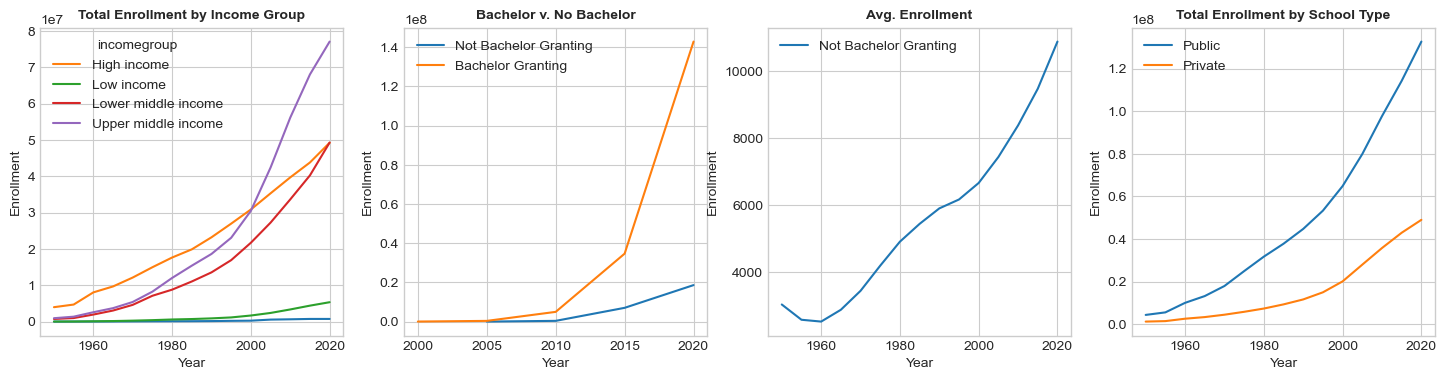

In [47]:
# Use seaborn here to quickly take advantage of the hue option
import seaborn as sns

# Create DF of only schools that report enrollments. Drop rows with NaN for students5_estimated.
enrollments = raw.dropna(subset=['students5_estimated'], axis=0)

fig, axs = plt.subplots(1,4, figsize=(18,4))
# Grouping by year, get the total enrollment in all institutions worldwide, separate by different other features
enroll_df_income = enrollments.groupby(by=['year', 'incomegroup'])[['students5_estimated']].sum().reset_index()
enroll_df_4year = enrollments.groupby(by=['year', 'b_granting'])[['students5_estimated']].sum().reset_index()
enroll_df_avg = enrollments.groupby(by=['year'])[['students5_estimated']].mean().reset_index()
enroll_df_pvt = enrollments.groupby(by=['year', 'private01'])[['students5_estimated']].sum().reset_index()

sns.lineplot(data=enroll_df_income, x='year', y='students5_estimated', hue='incomegroup', ax=axs[0])
sns.lineplot(data=enroll_df_4year, x='year', y='students5_estimated', hue='b_granting', ax=axs[1])
sns.lineplot(data=enroll_df_avg, x='year', y='students5_estimated', ax=axs[2])
sns.lineplot(data=enroll_df_pvt, x='year', y='students5_estimated', hue='private01', ax=axs[3])

# Graph legend and axis stuff
axs[0].set_title('Total Enrollment by Income Group', fontsize=10, fontweight='bold')

axs[1].set_title('Bachelor v. No Bachelor', fontsize=10, fontweight='bold')
axs[1].legend(['Not Bachelor Granting', 'Bachelor Granting'])

axs[2].set_title('Avg. Enrollment', fontsize=10, fontweight='bold')
axs[2].legend(['Not Bachelor Granting', 'Bachelor Granting'])

axs[3].set_title('Total Enrollment by School Type', fontsize=10, fontweight='bold')
axs[3].legend(['Public', 'Private'])

# Label axes
for i in range(4):
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Enrollment')
plt.show()

- **Income**:
    - By income group, it loooks like upper middle income enrollment has increased the most especially since 2000. Where are these institutions? For the united states, I only see institutions that are labeled "high income."
- **Bachelors Degrees**: 
    - It looks like there's no data on bachelor vs. non-bachelor granting data before 2000 and the schema mentions that this b_granting feature distinguishes institutions that only give PhDs It would have been nice to look at enrollment in 4-year universities vs. community colleges have changed over time. I know community college enrollments in the USA have gone way up.
- There definitely look to be some change points, but hard to comment on specific events without breaking it down by region/country. We'll break down total and average enrollments by country to see if we can isolate more "local" events.

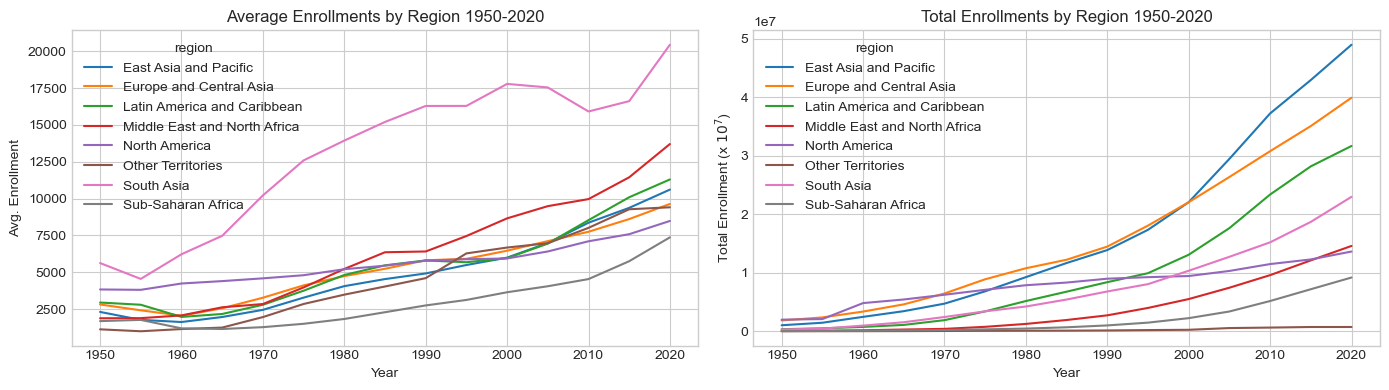

In [28]:
# Get regional enrollments over time. Easier to do with seaborn which has the hue option.
import seaborn as sns
fig, axs = plt.subplots(1,2, figsize=(14,4))

# Average Enrollments by Region
regional_enrollments = enrollments.groupby(by=['year', 'region'])[['students5_estimated']].mean().reset_index()
sns.lineplot(data=regional_enrollments, x='year', y='students5_estimated', hue='region', ax=axs[0])
axs[0].set_title('Average Enrollments by Region 1950-2020')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Avg. Enrollment')

# Total Enrollments by Region
total_enrollments = enrollments.groupby(by=['year', 'region'])[['students5_estimated']].sum().reset_index()
sns.lineplot(data=total_enrollments, x='year', y='students5_estimated', hue='region', ax=axs[1])
axs[1].set_title('Total Enrollments by Region 1950-2020')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Total Enrollment (x $10^7$)')
plt.tight_layout()
plt.show()

- There are various fluctuations in average enrollment but the general trend of the total enrollment is increasing somewhat non-linearly over time.
- For fun, let's make a world map showing college enrollments over time by countries around the world. Plotly can be used to do this at a basic level pretty quickly. It can show when countries created colleges and what their total higher education enrollment numbers look like over the second half of the 20th century.

In [293]:
import plotly.express as px

country_enrollments = enrollments.groupby(by=['year','country'])[['students5_estimated']].sum().reset_index()
country_enrollments.rename(columns={'students5_estimated': 'Total Students'}, inplace=True)

# For fun, make a world map that shows college enrollments over time
fig_map = px.choropleth(country_enrollments, locations='country', locationmode='country names',
                    color='Total Students', animation_frame='year',
                    color_continuous_scale='Reds', range_color=(0, country_enrollments['Total Students'].max()))

fig_map.update_layout(title_text='Total Number of Enrolled Students by Country', 
                      title={'xanchor': 'center', 'yanchor': 'top', 'x':0.5, 'y':0.9, 'font':{'size': 20}},
                      margin={'l': 0, 'r':0, 'b':0, 't':100},
                      height=600, width=800)

fig_map.show()

With the scales being different, it's still hard to tell specific changepoints at this level. We'll pick a couple of specific regions and look at enrollment numbers of the countries in each region with the 5 highest enrollments. 

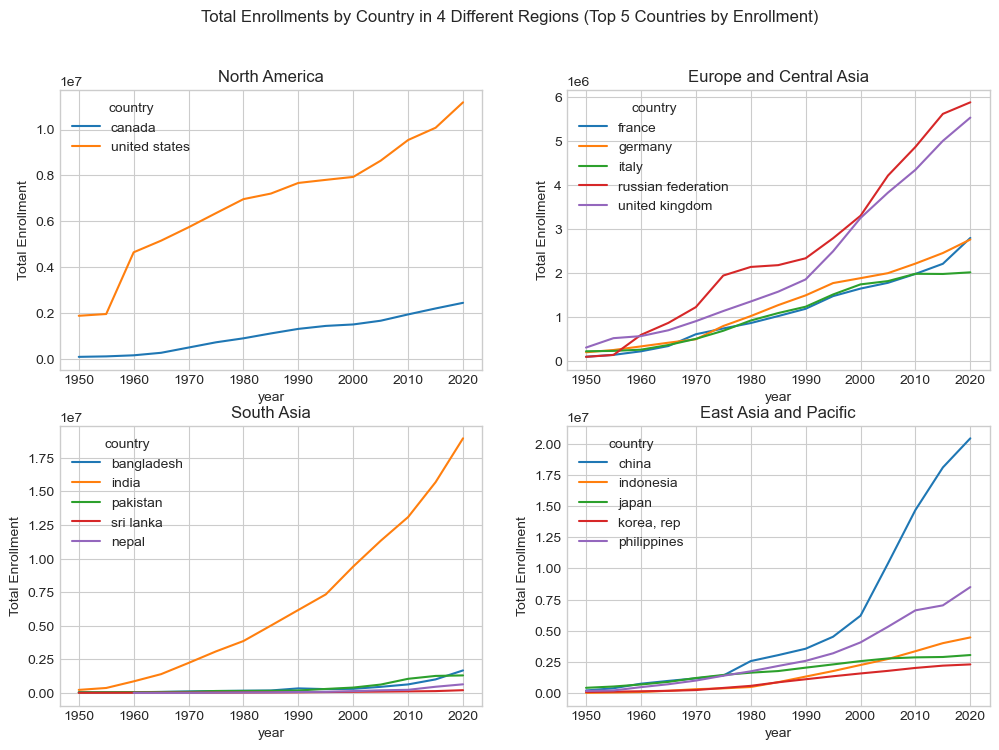

In [33]:
# Pick a few interesting regions
regions = ['North America', 'Europe and Central Asia', 'South Asia', 'East Asia and Pacific']   
fig, axs = plt.subplots(2,2, figsize=(12,8))
dfs = []
for region in regions:
    # Get total enrollments by country for each of the regions above
    temp = enrollments[enrollments.region == region].groupby(by=['year','country'])[['students5_estimated']].sum().reset_index()
    # Filter out only the top 5 countries by enrollment
    top5 = temp.groupby(by=['country'])['students5_estimated'].sum().nlargest(5).index.tolist()
    filtered = temp[temp['country'].isin(top5)]
    # Add to list of dfs
    dfs.append(filtered)

# Plot on the grid by iterating over axes    
for index, ax in enumerate(axs.flatten()):
    sns.lineplot(data=dfs[index], x='year', y='students5_estimated', hue='country', ax=ax)

fig.suptitle('Total Enrollments by Country in 4 Different Regions (Top 5 Countries by Enrollment)')

# Get title and label the y axis
for axis, region in zip(axs.flatten(), regions):
    axis.set_title(region)
    axis.set_ylabel('Total Enrollment')        

- Here we see some more stark change points. Let's pick a few countries and look at the percent changes in enrollment over time.
- In the USA for example (where we're more familiar with key sociopolitical events), we see a huge spike in the 1960's. We'll dive more into this shortly.

For our group of countries, let's make a DF of some aggregated data to make calculations easier:
1. Number of colleges
2. Total Number of enrolled students (to track participation in college overall...although not relative to population)
3. Avg Number of enrolled students per institution (to track size of universities)
4. The percent change of the total number of colleges and the total number of students

In [117]:
# Pick a few countries that might be interesting
countries = ['united states', 'china', 'india', 'russian federation', 'united kingdom', 'japan', 'france']

# Create dictionary of aggregated stats for our countries
dfs = {}
for country in countries:
    # Get some aggregated info
    num_colleges = enrollments[enrollments.country == country].groupby(by=['year'])[['iau_id1']].nunique().reset_index()
    total_students = enrollments[enrollments.country == country].groupby(by=['year'])[['students5_estimated']].sum().reset_index()
    avg_students = enrollments[enrollments.country == country].groupby(by=['year'])[['students5_estimated']].mean().reset_index()

    country_stats = pd.merge(num_colleges, total_students, on=['year']).merge(avg_students, on=['year'])
    country_stats.rename(
        columns={'iau_id1': 'num_colleges', 'students5_estimated_x': 'tot_enrollment', 'students5_estimated_y': 'avg_enrollment'}, inplace=True)
    country_stats['pct_ch_enroll'] = country_stats.tot_enrollment.pct_change()*100
    country_stats['pct_ch_colleges'] = country_stats.num_colleges.pct_change()*100
    
    dfs[country] = country_stats

dfs['india']

,year,num_colleges,tot_enrollment,avg_enrollment,pct_ch_enroll,pct_ch_colleges
0,1950,37,220739.0,5965.918945,NaN,NaN
1,1955,70,363679.0,5195.414062,64.755211,89.189189
2,1960,116,856661.0,7385.008789,135.554153,65.714286
3,1965,156,1394186.0,8937.089844,62.746525,34.482759
4,1970,181,2229099.0,12315.463867,59.885334,16.025641
5,1975,205,3089167.0,15069.107422,38.583660,13.259669
6,1980,226,3861085.0,17084.447266,24.987900,10.243902
7,1985,269,5010654.0,18626.966797,29.773212,19.026549
8,1990,314,6175481.0,19667.136719,23.247004,16.728625
9,1995,354,7334964.0,20720.236328,18.775595,12.738854


- Just looking through the data above we see a few notable HUGE shifts in both the number of enrollment in for example:
    1. China in 1955 saw 187.9% increase in the number of colleges and an 84% increase in the number of total students
    2. The USA in 1960 saw a 120% increase in the number of colleges and a 136% increase in the number of total students
    3. In Russia (I assume this for things now in modern day Russia) there was a 321.6% increase in enrollment in 1960 and decreases in the number of colleges since 2010
    4. In India enrollments went up by 135% in 1960.

- Let's now plot the percent change in the enrollment and the percent change in the number of schools to get a visual sense of when spikes happen for these countries. We'll put a couple of individual spikes in some sociopolitial/historical context.

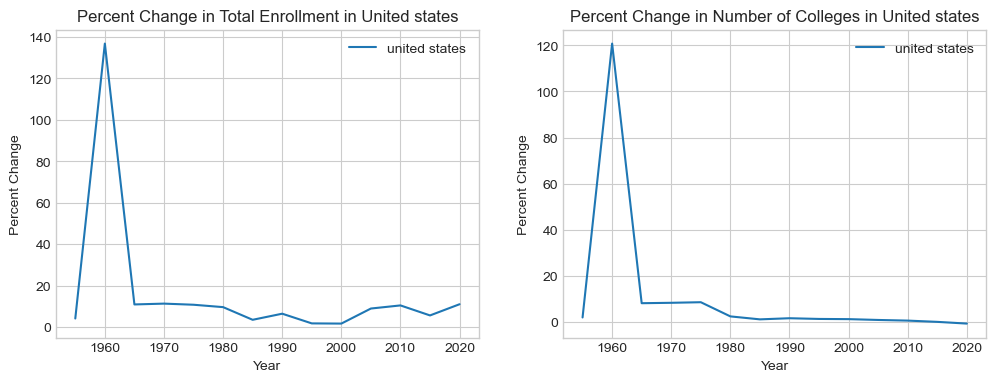

In [36]:
# Use matplotlib here so avoid having to melt df's for seaborn plots. More functionality with plt.plot than df.plot from pandas
def plot_changes(dfs, plots, countries, kind):
    fig, axs = plt.subplots(1,2, figsize=(12,4))
    for index, plot in enumerate(plots):
        for country in countries: 
            axs[index].plot(dfs[country]['year'], dfs[country][plot], label=country)

        title_string = 'Total Enrollment' if index == 0 else 'Number of Colleges'
        country_string = f'in {country.capitalize()}' if len(countries) == 1 else ''
        axs[index].set_title(f'Percent Change in {title_string} {country_string}')
        axs[index].set_xlabel('Year')
        axs[index].set_ylabel('Percent Change')
        #axs[index].set_yscale('log')
        axs[index].legend()

    plt.show()    

plots = ['pct_ch_enroll', 'pct_ch_colleges']
countries = ['united states']
plot_changes(dfs, plots, countries)

In the United States, there was a huge spike in enrollment in 1955-1965 range. There are number of potential reaons for this...
1. **The 1958 National Defense Education Act**
    - In part inspired by the Soviet launch of sputnik, this initiative made funds available for low-cost student loans
2. **The 1965 Higher Education Act**
    - Created work-study job opportunities, need-based grants, and outreach programs aimed at lower-income bracket
3. **Teacher Colleges**
    - Some teacher colleges (normal schools) began to start becoming full fledged univeresities, expanding enrollment. I believe James Madison Univ. is an example of this.
4. **The 1964 Civil Rights Act** 
    - May have increased african-american enrollments in colleges other than HBCUs (this info is not contained in the data obviously)    

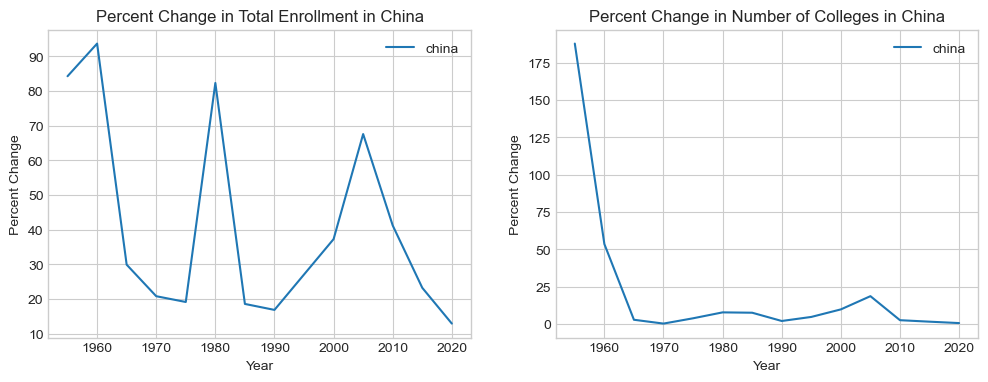

In [411]:
plot_changes(dfs, plots, ['china'])

We see huge spikes in the changes in enrollment in China which could be due to...
1. **1966-1976 Cultural Revolution:** 
    - Mao Zedong initiated China's Cultural Revolution in 1966 and it lasted until roughly 1976. 
    - During this time, restrictions were placed on who could enroll in universities. Professors were also limited in what they could teach, what books they could use, investigated for "imperialist" views. According to quick research, this had a negative affect on enrollments.
2. **1977 Four Modernizations:** 
    - Initiated by Den Xioping, impacted higher ed. Resumed the National Higher Education Examination. 
    - In the 1980's reforms began to address letting universities have more autonomy in planning their curricula and research efforts. Restrictions were pulled back on who could enroll. Universities could individually plan construction projects.
3. **Science and Technology Parks**: 
    - Very quick research mentions that in the 2000's, plans were initiated to continue to accelerate STEM research and education, build university technology centers, and reform hundreds of universities. This could help explain the spike we see in the mid 2000's.

We can check out some other interesting major countries below.

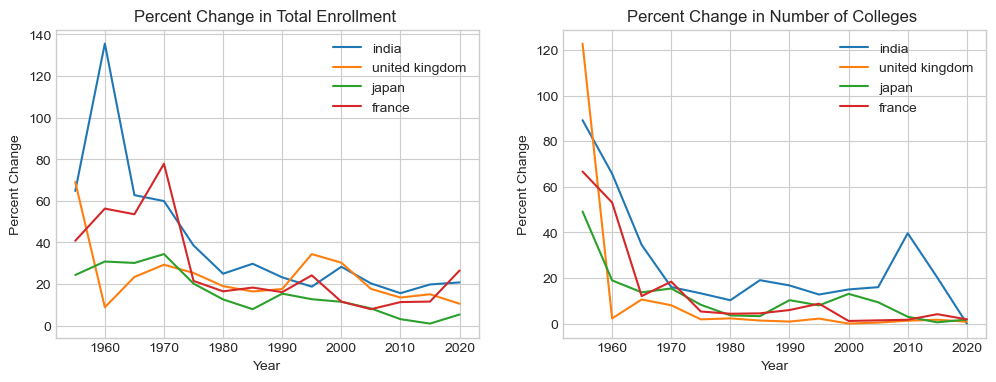

In [37]:
plot_changes(dfs, plots, ['india', 'united kingdom', 'japan', 'france'])

### Going Forward
- With more time, it would be useful to look into the following:
    1. **Income Brackets:** Especially in the USA, community college enrollments have gone up. Would be interesting to investigate.
    2. **Population Stats:** Would be interesting to see what percent of people 18-22 were enrolled at any given point. I know in the USA this peaked around 2008, especially in community colleges.
    2. **Modeling/Changepoint Detection:** There exist a variety of chanegpoint detection models such as ruptures, Facebook prophet, etc. and different techinques available. One could explore this to, in a more automated way, detect changepoints in all countries. You could also construct models (likely at the regional level) to predict enrollment over time.

#### ***Preliminary*** Changepoint Detection Experimentation
- Let's use the ruptures package to try to automatically detect changepoints in enrollment by country.
- There are different models in ruptures such as dynamic programming, PELT (Pruned Exact Linear Time), Binary Segmentation. We'll use Binary Segmentation to start.
- I looked at the distribution of the changepoints (breakpoints) of the total enrollments for all of the countries and found mostly uninteresting results, many of which just said what was already obvious from the above analysis...the 1960's and 1970's saw huge shifts in higher education.

In [68]:
!pip install ruptures

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.8/399.8 kB 2.5 MB/s eta 0:00:0000:0100:01


In [216]:
import ruptures as rpt

def plot_changepoints(dfs, country):
    """
    Plots the changepoints as calculated by use of the Python rupture package. By default, uses Binary Segmentation model.
    """
    df = enrollments[enrollments.country == country].groupby(by=['year'])[['students5_estimated']].sum().reset_index()
    
    time = np.array(df.year.tolist())
    feature = np.array(df.students5_estimated.tolist())

    model = rpt.Binseg(model='l2').fit(feature)
    breaks = model.predict(pen=3)
    
    plt.plot(time, feature)

    for b in breaks[:-1]:
        plt.axvline(x=time[b], color='red', linestyle='dashed', label='changepoints')

    plt.title(f'Total Enrollment in {country}')
    plt.xlabel('Year')
    plt.ylabel('Total Enrollment')
    plt.show()    

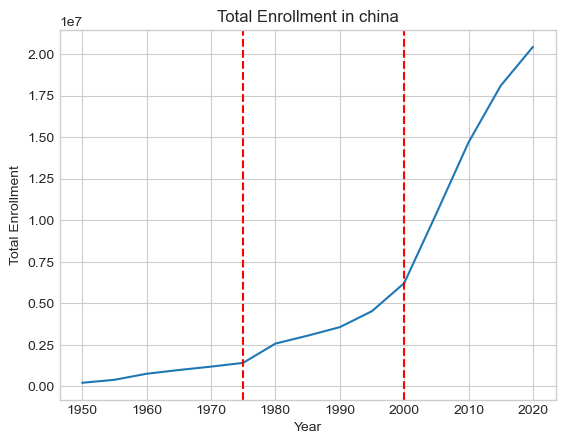

In [220]:
plot_changepoints(dfs, 'china')

Thanks for reading! LMK if you have any questions. There's obviously much more you could do here, especially in terms of leveraging more advanced models. That could be done with a bit more time.